# NN Classifier

---

Aditya Marathe

## Imports and version

In [1]:
%matplotlib inline

import sys

import numpy as np
import numpy.typing as npt

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local**:

In [2]:
sys.path.insert(1, './../')

import ana
from utils import *
from transforms import *

In [3]:
ana.init_global_plotting_style()

**Version**:

In [4]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')
print(f'Tensorflow {tf.__version__}')
print(f'SciKitLearn {skl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.1
Matplotlib 3.8.1
Tensorflow 2.10.1
SciKitLearn 1.3.2


## Loading the data

In [5]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [6]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        # ds.COPYMERGED_C8_DIR,  # type: ignore
        # ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [7]:
data.table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 184661 entries, (15021, 10, 0, 0, 1, 1) to (15112, 63, 0, 0, 1000, 2)
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   rec.energy.numu.E                   184661 non-null  float32
 1   rec.energy.numu.calccE              184661 non-null  float32
 2   rec.energy.numu.hadcalE             184661 non-null  float32
 3   rec.energy.numu.hadtrkE             184661 non-null  float32
 4   rec.energy.numu.lstmmuon            184661 non-null  float32
 5   rec.energy.numu.lstmnu              184661 non-null  float32
 6   rec.energy.numu.regcvnhadE          184661 non-null  float32
 7   rec.energy.numu.trkccE              184661 non-null  float32
 8   rec.energy.numu.recomuonE           184661 non-null  float32
 9   rec.energy.numu.hadclust.calE       184661 non-null  float32
 10  rec.energy.numu.hadclust.nhit       184661 non-nul

In [8]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)

## Data prep.

In [173]:
table = data.table.reset_index(drop=True)

In [174]:
cuts = ana.Cuts.init_nova_cuts()

In [175]:
# Cuts
table = cuts.apply_cut('Detector Quality', table)
table = cuts.apply_cut('Data Quality', table)
table = cuts.apply_cut('Cosmic Rej.', table)
table = cuts.apply_cut('Veto', table)
# table = cuts.apply_cut('CVN PID Score', table)
# table = cuts.apply_cut('Containment', table)

In [176]:
def tf_200224_add_cut_vars(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    df_copy = cuts.apply_cut('CVN PID Score', df_copy)
    passed_cvn_pid_index = df_copy.index

    df_copy = df.copy()

    df_copy = cuts.apply_cut('Containment', df_copy)
    passed_containment_index = df_copy.index
    
    #

    df_copy = df.copy()

    df_copy.loc[passed_cvn_pid_index, 'ana.cut.flag.cvn_pid'] = 1.
    df_copy.loc[passed_containment_index, 'ana.cut.flag.containment'] = 1.

    df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']] = df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']].fillna(value=0)

    return df_copy


In [177]:
# Transforms
table = tf_290124_positive_energies(table)
table = tf_290124_valid_pid(table)
table = tf_120224_first_prong(table)
table = tf_200224_add_cut_vars(table)

In [178]:
useful_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.cvnloosepreselptp.nutauid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
    'ana.cut.flag.cvn_pid',
    'ana.cut.flag.containment',
	'ana.mc.flag.isNuMuCC'
]

scale_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt'
]

In [282]:
useful_vars = [
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.recomuonE',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.scann.scpid',
    
    'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.sel.remid.pid',
	'rec.sel.cvnloosepreselptp.numuid',
    
	'ana.mc.flag.isNuMuCC'
]

scale_vars = [
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.recomuonE'
]

In [283]:
# Training data and labels
x_table = table[useful_vars]
y_table = x_table.pop('ana.mc.flag.isNuMuCC')

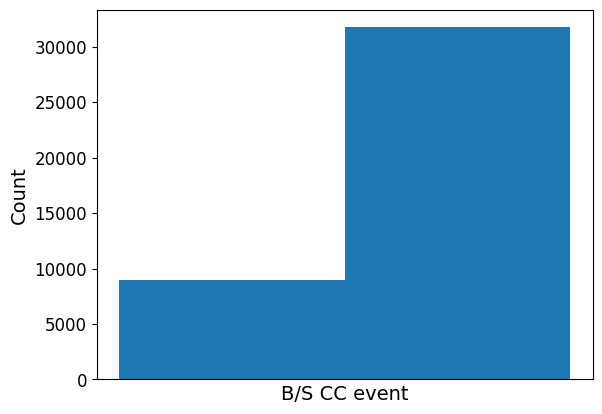

In [284]:
plt.hist(
    y_table.values,
    bins=np.linspace(0, 1, 2 + 1)  # type: ignore
)
plt.ylabel('Count')
plt.xlabel('B/S CC event')
plt.xticks([]);

In [285]:
x_train_table, x_test_table, y_train_table, y_test_table = train_test_split(
    x_table, y_table, test_size=0.2, random_state=42
)

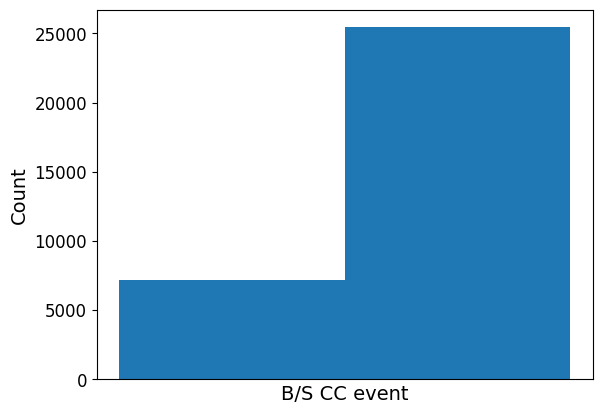

In [286]:
plt.hist(
    y_train_table.values,
    bins=np.linspace(0, 1, 2 + 1)  # type: ignore
)
plt.ylabel('Count')
plt.xlabel('B/S CC event')
plt.xticks([]);

## Model

In [287]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'CVN PID Score',
        'Cosmic Rej.',
        # 'Veto'
    ],
    'Transforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_120224_first_prong',
        'tf_200224_add_cut_vars'
    ],
    'XDataCols': useful_vars[:-1],
    'YDataCols': useful_vars[-1],
    'HyperParameters': dict()
}

In [294]:
model_config = {
    'SequentialLayers': [
        keras.layers.InputLayer(input_shape=(len(useful_vars[:-1]),)),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(units=1, activation=keras.activations.sigmoid)
    ],
    'Optimizer': keras.optimizers.Adam(learning_rate=1E-3),
    'LossFunction': keras.losses.BinaryCrossentropy()
}

In [295]:
def init_model() -> keras.Sequential:
    """\
    """
    model = keras.Sequential(layers=model_config['SequentialLayers'])

    model.compile(
        optimizer=model_config['Optimizer'],
        loss=model_config['LossFunction'],
        metrics=[
            keras.metrics.BinaryAccuracy(),  # threshold=0.5
            keras.metrics.Precision(),
            keras.metrics.Recall()
        ]
    )

    model.summary()

    return model

In [296]:
model = init_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 8)                 112       
                                                                 
 batch_normalization_18 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_23 (Dense)            (None, 16)                144       
                                                                 
 batch_normalization_19 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16)               

In [297]:
history_obj = model.fit(
    x_train_table, 
    y_train_table,
    validation_split=0.2,
    epochs=100,
    class_weight={0: 78, 1: 21}
)

Epoch 1/100
815/815 [==============================] - 15s 10ms/step - loss: 25.6967 - binary_accuracy: 0.4955 - precision_4: 0.7921 - recall_4: 0.4786 - val_loss: 0.6763 - val_binary_accuracy: 0.5184 - val_precision_4: 0.8338 - val_recall_4: 0.4814
Epoch 2/100
815/815 [==============================] - 7s 9ms/step - loss: 23.6641 - binary_accuracy: 0.4757 - precision_4: 0.8055 - recall_4: 0.4318 - val_loss: 0.7062 - val_binary_accuracy: 0.3852 - val_precision_4: 0.8663 - val_recall_4: 0.2549
Epoch 3/100
815/815 [==============================] - 6s 8ms/step - loss: 23.3010 - binary_accuracy: 0.4506 - precision_4: 0.8166 - recall_4: 0.3809 - val_loss: 0.6948 - val_binary_accuracy: 0.4389 - val_precision_4: 0.8707 - val_recall_4: 0.3336
Epoch 4/100
815/815 [==============================] - 7s 8ms/step - loss: 23.1367 - binary_accuracy: 0.4487 - precision_4: 0.8204 - recall_4: 0.3750 - val_loss: 0.6836 - val_binary_accuracy: 0.5170 - val_precision_4: 0.8535 - val_recall_4: 0.4632
Epoch 

In [298]:
label_counts = y_train_table.value_counts()
print(f'Sig: {label_counts[1] / len(y_train_table):0.5f} %')
print(f'Bak: {label_counts[0] / len(y_train_table):0.5f} %')

Sig: 0.78046 %
Bak: 0.21954 %


In [299]:
prediction = model.predict(x_test_table)

255/255 [==============================] - 1s 2ms/step


In [300]:
y_test_table.values

array([1., 1., 1., ..., 1., 1., 1.])

In [301]:
prediction.flatten()

array([0.7230566 , 0.74226743, 0.91276443, ..., 0.92389464, 0.8612932 ,
       0.20655242], dtype=float32)

In [302]:
((prediction > 0.5) * 1.).flatten()

array([1., 1., 1., ..., 1., 1., 0.])

In [303]:
y_test_table.values * ((prediction > 0.5) * 1.).flatten()

array([1., 1., 1., ..., 1., 1., 0.])

In [304]:
y_test_table == ((prediction > 0.5) * 1.).flatten()

85424      True
60108      True
137432     True
102209     True
141044     True
          ...  
105050     True
168766     True
49362      True
43         True
85382     False
Name: ana.mc.flag.isNuMuCC, Length: 8147, dtype: bool

In [305]:
threshold_values = np.linspace(0, 1, 100)
efficiency_arr = []
accuracy_arr = []

for t in threshold_values:
    predicted_vals = ((prediction > t) * 1.).flatten()
    # Efficiency
    correct_predictions = y_test_table.values * predicted_vals
    predicted_signals = len(correct_predictions[correct_predictions == 1.])
    efficiency = predicted_signals / len(y_test_table.values)
    efficiency_arr.append(efficiency)
    # Accuracy
    bool_arr = (y_test_table == predicted_vals) * 1.
    acc = len(bool_arr[bool_arr > 0]) / len(bool_arr)
    accuracy_arr.append(acc)


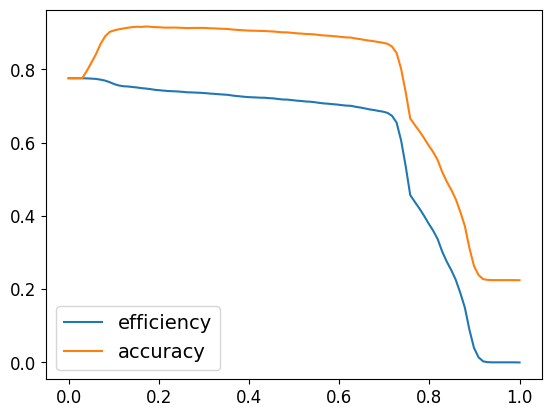

In [306]:
plt.plot(threshold_values, efficiency_arr, label='efficiency')
plt.plot(threshold_values, accuracy_arr, label='accuracy')
plt.legend();

In [307]:
b_arr = []
s_arr = []

for t in threshold_values:
    sel = y_test_table.reset_index(drop=True)[prediction.flatten() > t]
    s_arr.append(sel.value_counts().get(1) or 0)
    b_arr.append(sel.value_counts().get(0) or 0)

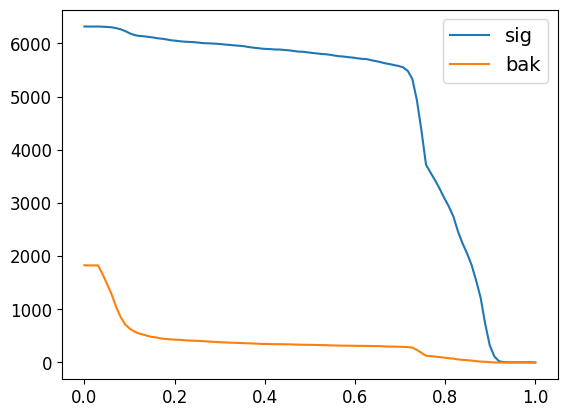

In [308]:
plt.plot(threshold_values, s_arr, label='sig')
plt.plot(threshold_values, b_arr, label='bak')
plt.legend();

In [309]:
y_test_table.value_counts()

ana.mc.flag.isNuMuCC
1.0    6319
0.0    1828
Name: count, dtype: int64

In [314]:
_a = ((prediction > 0.7) * 1.).flatten() 
len(_a[_a == 1])

5865

In [311]:
import labbook

In [315]:
labbook.add_log(
    comments='Classifier #3',
    config_dict=config,
    train_history=history_obj,
    model=model,
    seralise_objects=None,
    lb_dir='./../../labbook/'
)

LabBook | 20-02-2024 11:11 | Log saved!
